# N05B - Fully Supervised Training with Parameterised Signals using Low-Level Features

## Step 1: Data Loading

- Data is stored in the form of TFRecord files that can be loaded lazily into tensorflow dataset

In [1]:
import sys
import os
def set_scripts_path(scripts_path, undo=False):
    if (scripts_path in sys.path) and (undo==True):
        print('INFO: Removed {} from $PYTHONPATH'.format(scripts_path))
        sys.path.remove(scripts_path)
        os.environ["PYTHONPATH"].replace(scripts_path+":","")
        
    if (scripts_path not in sys.path) and (undo==False):
        print('INFO: Adding {} to $PYTHONPATH'.format(scripts_path))
        sys.path.insert(0, scripts_path)
        os.environ["PYTHONPATH"] = scripts_path + ":" + os.environ.get("PYTHONPATH", "")

In [2]:
set_scripts_path("/global/homes/c/chlcheng/Repository/quickstats")

INFO: Adding /global/homes/c/chlcheng/Repository/quickstats to $PYTHONPATH


In [3]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from aliad.interface.tensorflow.dataset import (apply_pipelines, split_dataset, get_tf_inputs,
                                                get_ndarray_tfrecord_example_parser)

dirname = '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/'
filenames = glob.glob(os.path.join(dirname, 'SR_*_shuffled_shard_*.tfrec'))
metadata_filename = os.path.join(dirname, 'SR_point_cloud_train_features_all_signals_all_backgrounds_metadata.json')

metadata = json.load(open(metadata_filename))

In [4]:
metadata['features']

{'part_coords': {'shape': [2, 300, 2], 'dtype': 'float64'},
 'part_features': {'shape': [2, 300, 4], 'dtype': 'float64'},
 'jet_features': {'shape': [2, 7], 'dtype': 'float64'},
 'part_masks': {'shape': [2, 300], 'dtype': 'bool'},
 'label': {'shape': [1], 'dtype': 'int64'},
 'weight': {'shape': [1], 'dtype': 'float64'},
 'm1': {'shape': [1], 'dtype': 'float64'},
 'm2': {'shape': [1], 'dtype': 'float64'}}

In [5]:
metadata['sample_size']

{'QCD': 121351,
 'extra_QCD': 612853,
 'W_50_450': 72728,
 'W_400_50': 44016,
 'W_500_600': 59319,
 'W_500_250': 68873,
 'W_350_500': 69686,
 'W_250_450': 72477,
 'W_450_350': 70912,
 'W_600_100': 48551,
 'W_50_100': 76327,
 'W_450_500': 67605,
 'W_100_400': 74261,
 'W_450_200': 70539,
 'W_600_300': 62038,
 'W_50_150': 76482,
 'W_500_500': 65754,
 'W_300_250': 74743,
 'W_450_600': 61071,
 'W_50_300': 75557,
 'W_200_500': 71231,
 'W_150_200': 76421,
 'W_500_50': 33154,
 'W_50_50': 75286,
 'W_150_300': 75953,
 'W_100_300': 75777,
 'W_400_450': 70527,
 'W_400_150': 70112,
 'W_100_500': 71493,
 'W_350_50': 49591,
 'W_250_150': 74473,
 'W_100_450': 73157,
 'W_350_250': 73947,
 'W_600_450': 60922,
 'W_150_400': 74239,
 'W_150_50': 70476,
 'W_50_500': 70855,
 'W_200_550': 68501,
 'W_250_600': 64278,
 'W_100_100': 76373,
 'W_400_550': 66384,
 'W_200_200': 75929,
 'W_150_600': 64707,
 'W_150_450': 72899,
 'W_300_500': 70313,
 'W_500_100': 58176,
 'W_550_50': 27970,
 'W_300_400': 73486,
 'W_100_

In [6]:
# method to extract the feature vectors and label from the tfrecord
def get_input(X):
    return (X['part_coords'], X['part_features'], X['part_masks'], X['jet_features']), X['label']

def get_dataset(filenames, base_parse_func, input_parse_func, batch_size):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(base_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(input_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    # datasets pre-shuffled, no need to shuffle again
    ds = apply_pipelines(ds, batch_size=batch_size,
                         shuffle=False, prefetch=True)
    return ds

batch_size = 128
# method for parsing the binary tfrecord into array data
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
# each file contains 100k events and are pre-shuffled, so we just use diferent set of files for train, validation and test
ds_train = get_dataset(filenames[:50], parse_tfrecord_fn, get_input, batch_size=batch_size)
ds_val   = get_dataset(filenames[50:75], parse_tfrecord_fn, get_input, batch_size=batch_size)
ds_test  = get_dataset(filenames[75:100], parse_tfrecord_fn, get_input, batch_size=batch_size)

2023-11-25 02:16:19.001854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 02:16:20.811964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-11-25 02:16:20.813451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78933 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-11-25 02:16:20.814924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [7]:
print(f'tensorflow version  : {tf.__version__}')
!nvcc --version

tensorflow version  : 2.9.0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#if len(physical_devices) > 0:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

## Step 2: Create ParticleNet Model

In [9]:
from typing import Optional, Union, List, Tuple

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (BatchNormalization, Activation,
                                     Conv3D, Dense, Dropout)

from quickstats import semistaticmethod, AbstractObject
from quickstats.utils.common_utils import combine_dict

from aliad.interface.tensorflow.layers import EdgeConv

class ModifiedParticleNet(AbstractObject):

    DEFAULT_CONFIG = {
        "num_points"  : 300,
        "num_jets"    : 2,
        "num_class"   : 1,
        "K"           : 16,
        "conv_params" : [(64, 64, 64),
                         (128, 128, 128),
                         (256, 256, 256)],
        "fc_params"   : [(256, 0.1)],
        "pool_method" : "average",
        "batchnorm"   : True,
        "activation"  : "relu"
    }
    
    def __init__(self, config:Optional[dict]=None,
                 verbosity:str="INFO"):
        super().__init__(verbosity=verbosity)
        self.config = combine_dict(self.DEFAULT_CONFIG, config)
    
    def get_model(self, points, features=None, masks=None,
                  jet_features=None, name='ParticleNet'):
        # points       : (nevent, njet, nparticle, ncoords)
        # features     : (nevent, njet, nparticle, nfeatures)
        # masks        : (nevent, njet, nparticle, 1)
        # jet_features : (nevent, njet, njetfeatures)
    
        with tf.name_scope(name):
            if features is None:
                features = points
    
            if masks is not None:
                coord_shift = tf.multiply(99., tf.cast(tf.expand_dims(masks, axis=-1), dtype='float32'))
            else:
                coord_shift = None
            fts = tf.expand_dims(features, axis=-2)
            fts = BatchNormalization(name=f"{name}_fts_bn")(fts)
            fts = tf.squeeze(fts, axis=-2)
            for layer_idx, layer_channels in enumerate(self.config['conv_params']):
                pts = points if layer_idx == 0 else fts
                if masks is not None:
                    pts = tf.add(coord_shift, pts)
                fts = EdgeConv(pts, fts, channels=layer_channels,
                               K=self.config['K'], 
                               batchnorm=self.config['batchnorm'],
                               activation=self.config['activation'],
                               pooling=self.config['pool_method'],
                               name=f'{name}_EdgeConv{layer_idx}')
    
            if masks is not None:
                fts_mask = tf.cast(tf.math.logical_not(tf.expand_dims(masks, axis=-1)), dtype='float32')
                fts = tf.multiply(fts, fts_mask)

            # shape = (nevent, njet, nchannel)
            pool = tf.reduce_mean(fts, axis=-2)
            if jet_features is not None:
                pool = tf.concat([pool, jet_features], -1)
            pool_shape = tf.shape(pool)
            out = tf.reshape(pool, (-1, tf.reduce_prod(pool_shape[1:])))
    
            if self.config['fc_params'] is not None:
                x = out
                for layer_idx, layer_param in enumerate(self.config['fc_params']):
                    units, drop_rate = layer_param
                    x = Dense(units, activation='relu')(x)
                    if drop_rate is not None and drop_rate > 0:
                        x = Dropout(drop_rate)(x)
                out = Dense(self.config['num_class'], activation='sigmoid')(x)
                
            inputs = [points, features]
            if masks is not None:
                inputs.append(masks)
            if jet_features is not None:
                inputs.append(jet_features)
        model = Model(inputs=inputs, outputs=out, name=name)
        return model

In [10]:
# total number of train samples
batch_size = 128
total_size = int(100_000 * 100 * 0.5)
steps_per_epoch = total_size / batch_size
config = {
    # for binary classification
    'loss'       : 'binary_crossentropy',
    'metrics'    : ['accuracy'],
    'epochs'     : 20,
    'optimizer'  : 'Adam',
    'optimizer_config': {
        'learning_rate': 0.001
    },
    'checkpoint_dir': '/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/'
                      'param_low_level_10M_events_SR_v1',
    'callbacks': {
        'lr_scheduler': {
            'initial_lr': 0.001,
            'lr_decay_factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6
        },
        'early_stopping': {
            'monitor': 'val_loss',
            'patience': 3
        },
        'model_checkpoint':{
            'save_weights_only': True,
            # save model checkpoint every epoch
            'save_freq': int(steps_per_epoch * 1)
        }
    }
}

In [11]:
import copy
feature_metadata = copy.deepcopy(metadata['features'])
for label, metadata_ in feature_metadata.items():
    if metadata_['dtype'] == 'float64':
        metadata_['dtype'] = 'float32'

In [8]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
with strategy.scope():
    Inputs = get_tf_inputs(feature_metadata)
    model_builder = ModifiedParticleNet()
    model = model_builder.get_model(Inputs['part_coords'],
                                    Inputs['part_features'],
                                    masks=Inputs['part_masks'],
                                    jet_features=Inputs['jet_features'])
    optimizer = tf.keras.optimizers.get({'class_name': config['optimizer'], 'config': config['optimizer_config']})
    model.compile(loss=config['loss'],
                  optimizer=optimizer,
                  metrics=config['metrics'])

2023-11-24 11:27:22.042217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 11:27:23.783702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-11-24 11:27:23.785218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78933 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-11-24 11:27:23.786714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

### Prepare callbacks

In [9]:
from aliad.interface.tensorflow.callbacks import LearningRateScheduler, BatchMetricsCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = config['checkpoint_dir']
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

lr_scheduler = LearningRateScheduler(**config['callbacks']['lr_scheduler'])

early_stopping = EarlyStopping(**config['callbacks']['early_stopping'])

checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_weights_epoch_{epoch:02d}.h5'),
                             **config['callbacks']['model_checkpoint'])
batch_metrics = BatchMetricsCallback()
callbacks = [lr_scheduler, early_stopping, checkpoint, batch_metrics]

## Step 3: Train Model

In [ ]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          callbacks=callbacks)

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1


2023-11-23 04:01:09.422417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 04:01:10.426040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 04:01:11.421761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 04:01:12.079730: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 04:01:12.403443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39062/39062 [==============================] - 3523s 90ms/step - loss: 0.0731 - accuracy: 0.9728 - val_loss: 0.0655 - val_accuracy: 0.9757
Epoch 2/20
39062/39062 [==============================] - 3499s 90ms/step - loss: 0.0659 - accuracy: 0.9754 - val_loss: 0.0632 - val_accuracy: 0.9766
Epoch 3/20
39062/39062 [==============================] - 3499s 90ms/step - loss: 0.0635 - accuracy: 0.9764 - val_loss: 0.0624 - val_accuracy: 0.9773
Epoch 4/20
39062/39062 [==============================] - 3500s 90ms/step - loss: 0.0622 - accuracy: 0.9769 - val_loss: 0.0612 - val_accuracy: 0.9775
Epoch 5/20
 1805/39062 [>.............................] - ETA: 41:44 - loss: 0.0609 - accuracy: 0.9776

### Resume training

In [11]:
model.load_weights(os.path.join(config['checkpoint_dir'], 'model_weights_epoch_04.h5'))

In [ ]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          initial_epoch=4,
          callbacks=callbacks)

Epoch 5/20
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1


2023-11-23 13:35:37.340630: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 13:35:37.929082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 13:35:38.662266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 13:35:39.341358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 13:35:40.594044: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39062/39062 [==============================] - 3720s 95ms/step - loss: 0.0612 - accuracy: 0.9772 - val_loss: 0.0605 - val_accuracy: 0.9778
Epoch 6/20
39062/39062 [==============================] - 3691s 94ms/step - loss: 0.0604 - accuracy: 0.9775 - val_loss: 0.0598 - val_accuracy: 0.9779
Epoch 7/20
39062/39062 [==============================] - 3694s 95ms/step - loss: 0.0596 - accuracy: 0.9778 - val_loss: 0.0595 - val_accuracy: 0.9780
Epoch 8/20
39062/39062 [==============================] - 3693s 95ms/step - loss: 0.0591 - accuracy: 0.9780 - val_loss: 0.0593 - val_accuracy: 0.9783
Epoch 9/20
39062/39062 [==============================] - 3692s 95ms/step - loss: 0.0586 - accuracy: 0.9782 - val_loss: 0.0588 - val_accuracy: 0.9784
Epoch 10/20
33102/39062 [========================>.....] - ETA: 7:06 - loss: 0.0581 - accuracy: 0.9783

In [12]:
model.load_weights(os.path.join(config['checkpoint_dir'], 'model_weights_epoch_09.h5'))

In [ ]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          initial_epoch=9,
          callbacks=callbacks)

Epoch 10/20
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1


2023-11-23 19:38:40.281175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 19:38:40.878248: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 19:38:41.585498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 19:38:42.237057: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-23 19:38:43.822266: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39062/39062 [==============================] - 3800s 97ms/step - loss: 0.0582 - accuracy: 0.9784 - val_loss: 0.0589 - val_accuracy: 0.9785
Epoch 11/20
39062/39062 [==============================] - 3771s 97ms/step - loss: 0.0578 - accuracy: 0.9784 - val_loss: 0.0585 - val_accuracy: 0.9787
Epoch 12/20
39062/39062 [==============================] - 3773s 97ms/step - loss: 0.0575 - accuracy: 0.9786 - val_loss: 0.0582 - val_accuracy: 0.9786
Epoch 13/20
39062/39062 [==============================] - 3773s 97ms/step - loss: 0.0571 - accuracy: 0.9787 - val_loss: 0.0579 - val_accuracy: 0.9788
Epoch 14/20
39062/39062 [==============================] - 3771s 97ms/step - loss: 0.0568 - accuracy: 0.9788 - val_loss: 0.0578 - val_accuracy: 0.9787
Epoch 15/20
31392/39062 [=======================>......] - ETA: 9:26 - loss: 0.0564 - accuracy: 0.9790

In [11]:
model.load_weights(os.path.join(config['checkpoint_dir'], 'model_weights_epoch_14.h5'))

In [ ]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          initial_epoch=14,
          callbacks=callbacks)

Epoch 15/20
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1


2023-11-24 02:34:43.081332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 02:34:44.070063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 02:34:45.024642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 02:34:45.708862: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 02:34:45.968511: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39062/39062 [==============================] - 3667s 93ms/step - loss: 0.0565 - accuracy: 0.9789 - val_loss: 0.0577 - val_accuracy: 0.9787
Epoch 16/20
39062/39062 [==============================] - 3643s 93ms/step - loss: 0.0562 - accuracy: 0.9790 - val_loss: 0.0576 - val_accuracy: 0.9788
Epoch 17/20
39062/39062 [==============================] - 3644s 93ms/step - loss: 0.0560 - accuracy: 0.9791 - val_loss: 0.0580 - val_accuracy: 0.9784
Epoch 18/20
39062/39062 [==============================] - 3644s 93ms/step - loss: 0.0557 - accuracy: 0.9792 - val_loss: 0.0574 - val_accuracy: 0.9788
Epoch 19/20
39062/39062 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9793

In [12]:
model.load_weights(os.path.join(config['checkpoint_dir'], 'model_weights_epoch_19.h5'))

In [13]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          initial_epoch=19,
          callbacks=callbacks)

Epoch 20/20
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 42 all-reduces with algorithm = nccl, num_packs = 1


2023-11-24 11:27:58.393160: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 11:27:59.000520: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 11:27:59.753408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 11:28:00.377757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 11:28:01.484249: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39062/39062 [==============================] - 3682s 94ms/step - loss: 0.0552 - accuracy: 0.9794 - val_loss: 0.0573 - val_accuracy: 0.9786


In [15]:
# load the best model
model.load_weights(os.path.join(config['checkpoint_dir'], 'model_weights_epoch_16.h5'))
# save entire model
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model.save(filename)

## Step 4 - Model Testing

In [9]:
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = tf.keras.models.load_model(filename)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

### Prediction on the full dataset (25% of 10M events, mixed signals)

In [10]:
predicted_proba = model.predict(ds_test).flatten()
y_pred = np.round(predicted_proba)
y_true = np.array([y for _, y in ds_test]).flatten()

2023-11-24 19:39:32.363581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 19:39:33.312539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 19:39:34.214169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 19:39:34.857443: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-11-24 19:39:35.285529: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


19531/19531 [==============================] - 782s 40ms/step


In [16]:
indices = y_true == 0

In [17]:
np.mean(y_pred[indices] == y_true[indices])

0.787099322734481

In [11]:
def get_mass_points(filenames, base_parse_func, batch_size):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(base_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x: [x['m1'][0], x['m2'][0]])
    ds = apply_pipelines(ds, batch_size=batch_size,
                         shuffle=False, prefetch=True)
    return ds

ds_test_masses = get_mass_points(filenames[75:100], parse_tfrecord_fn, batch_size=batch_size)

mass_points = np.array([d for d in ds_test_masses])

In [12]:
mass_points_  =np.transpose(mass_points, axes=(0, 2, 1))
mass_points_ = mass_points_.reshape((np.product(mass_points_.shape[:-1]), mass_points_.shape[-1]))
m1 = mass_points_[:, 0]
m2 = mass_points_[:, 1]

In [13]:
predicted_results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'm1': m1,
    'm2': m2
}
import pandas as pd
df = pd.DataFrame(predicted_results)

In [14]:
filename = os.path.join(config['checkpoint_dir'], "prediction.parquet")
df.to_parquet(filename, engine='fastparquet')

### Create ROC curves

In [12]:
import os
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "prediction.parquet")
df = pd.read_parquet(filename)

In [39]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from scipy.interpolate import interp1d
epsilon = 1e-4

def get_bootstrap_prediction(y_prob, y_true, num_bootstrap_samples:int=20,
                             seed:int=2023):
    np.random.seed(seed)
    bootstrap_y_prob = []
    bootstrap_y_true = []
    sample_size = y_prob.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        indices = np.random.choice(sample_size, sample_size, replace=True)
        y_prob_i = y_prob[indices]
        y_true_i = y_true[indices]
        bootstrap_y_prob.append(y_prob_i)
        bootstrap_y_true.append(y_true_i)
    bootstrap_y_prob = np.array(bootstrap_y_prob)
    bootstrap_y_true = np.array(bootstrap_y_true)
    return bootstrap_y_prob, bootstrap_y_true

def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=1000, mean=False):

    # interpolation
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs_list:
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tpr_manual = np.linspace(max_min_tpr, min_max_tpr, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        roc_function = interp1d(tpr, 1/(fpr+epsilon))
        sic_function = interp1d(tpr, tpr/((fpr+epsilon)**(0.5)))
        roc_interpol.append(roc_function(tpr_manual))
        sic_interpol.append(sic_function(tpr_manual))
                     
    # calculating mean+std or median+quantiles
    if mean:
        roc_median = np.mean(np.stack(roc_interpol), axis=0)
        sic_median = np.mean(np.stack(sic_interpol), axis=0)
        roc_std = np.std(np.stack(roc_interpol), axis=0)
        sic_std = np.std(np.stack(sic_interpol), axis=0)
        roc_std = (roc_median-roc_std, roc_median+roc_std)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        roc_median = np.median(np.stack(roc_interpol), axis=0)
        sic_median = np.median(np.stack(sic_interpol), axis=0)
        roc_std = (np.quantile(np.stack(roc_interpol), 0.16, axis=0), np.quantile(np.stack(roc_interpol), 0.84, axis=0))
        sic_std = (np.quantile(np.stack(sic_interpol), 0.16, axis=0), np.quantile(np.stack(sic_interpol), 0.84, axis=0))
    
    return tpr_manual, roc_median, sic_median, roc_std, sic_std

def get_roc_curve_data(y_prob, y_true, num_bootstrap_samples:int=20, seed:int=2023):
    bootstrap_y_prob, bootstrap_y_true = get_bootstrap_prediction(y_prob,
                                                                  y_true,
                                                                  num_bootstrap_samples=num_bootstrap_samples,
                                                                  seed=2023)
    bootstrap_fpr, bootstrap_tpr= [], []
    for i in range(num_bootstrap_samples):
        bs_fpr, bs_tpr, _ = roc_curve(bootstrap_y_true[i], bootstrap_y_prob[i])
        bootstrap_fpr.append(bs_fpr)
        bootstrap_tpr.append(bs_tpr)
    tpr_manual, roc_median, _, roc_std, _ = compute_median_and_variance_roc_sic(bootstrap_tpr,
                                                                                bootstrap_fpr)
    result = {
        'tpr': tpr_manual,
        'fpr_inv': roc_median,
        'errlo': roc_std[0],
        'errhi': roc_std[1]
    }
    return result

In [56]:
num_bootstrap_samples = 100
seed = 2023
mass_points = ['inclusive', '500_100', '100_500', '150_150', '200_300']
dfs = {}
aucs = {}
for mass_point in mass_points:
    key = f'{mass_point}_ll'
    df_m = df
    if mass_point != 'inclusive':
        m1, m2 = mass_point.split("_")
        df_m = df_m.query(f'((m1 == {m1}) & (m2 == {m2})) or '
                          f'((m1 == 0) & (m2 == 0))')
    y_prob = df_m['predicted_proba'].values
    y_true = df_m['y_true'].values
    data = get_roc_curve_data(y_prob, y_true, num_bootstrap_samples, seed=seed)
    dfs[key] = pd.DataFrame(data).query(f'fpr_inv < {1/epsilon}')
    aucs[key] = auc(1/data['fpr_inv'], data['tpr'])

<Figure size 640x480 with 0 Axes>

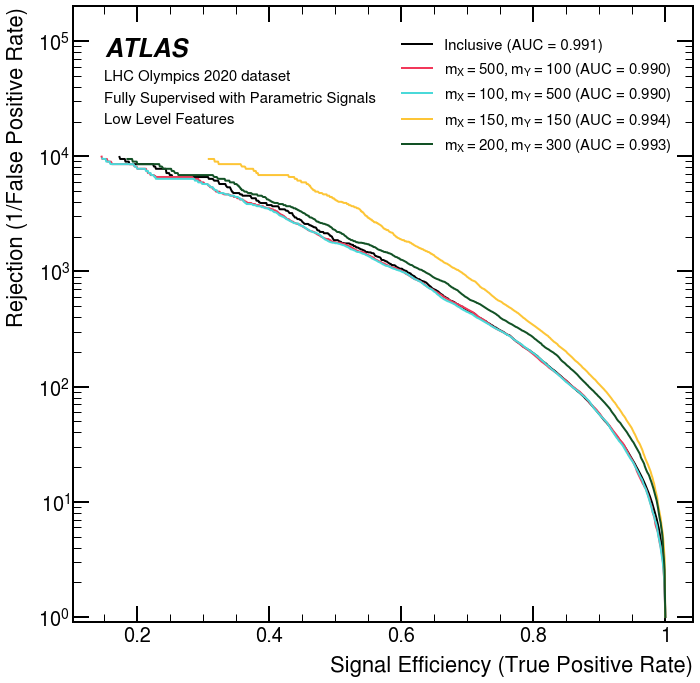

In [60]:
from quickstats.plots import General1DPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'dy': 0.03,
    'dy_main': 0,
    'loc': (0.05, 0.95),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Parametric Signals//Low Level Features'
}
styles = {
    'figure': {
        'figsize': (11.111, 11.111),
    },
    'legend': {
        'loc': (0.52, 0.75),
        'fontsize': 15
    },
    'text': {
        'fontsize': 15
    }
}
label_map = {}
for mass_point in mass_points:
    key = f'{mass_point}_ll'
    roc_auc = aucs[key]
    if 'inclusive' in mass_point:
        label = f'Inclusive'
    else:
        m1, m2 = mass_point.split("_")
        label = f'$m_X={m1}, m_Y={m2}$'
    label += f' (AUC = {roc_auc:.3f})'
    label_map[key] = label    
plotter = General1DPlot(dfs, analysis_label_options=analysis_label_options, color_cycle='default', styles=styles, label_map=label_map)    
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)",
                  ymax=2e5,
                  ymin=0.9)
#ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)

### Comparison with High Level Features

In [62]:
import os
import pandas as pd
hl_dirname = "/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/param_high_level_10M_events_SR_v1"
filename = os.path.join(ll_dirname, "prediction.parquet")
df_hl = pd.read_parquet(filename)

In [68]:
num_bootstrap_samples = 100
seed = 2023
mass_points = ['inclusive', '500_100', '100_500', '150_150', '200_300']
for mass_point in mass_points:
    key = f'{mass_point}_hl'
    df_m = df_hl
    if mass_point != 'inclusive':
        m1, m2 = mass_point.split("_")
        df_m = df_m.query(f'((m1 == {m1}) & (m2 == {m2})) or '
                          f'((m1 == 0) & (m2 == 0))')
    y_prob = df_m['predicted_proba'].values
    y_true = df_m['y_true'].values
    data = get_roc_curve_data(y_prob, y_true, num_bootstrap_samples, seed=seed)
    dfs[key] = pd.DataFrame(data).query(f'fpr_inv < {1/epsilon}')
    aucs[key] = auc(1/data['fpr_inv'], data['tpr'])

<Figure size 640x480 with 0 Axes>

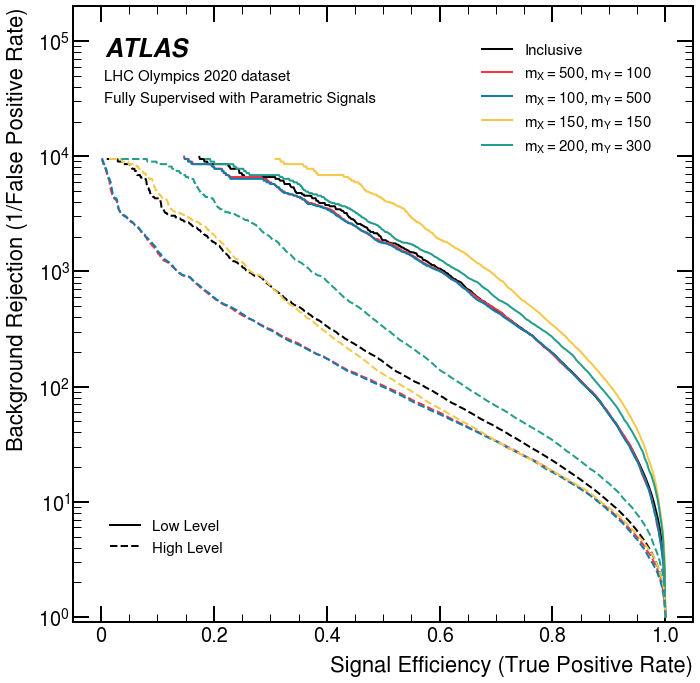

In [102]:
from quickstats.plots import General1DPlot, get_cmap
import matplotlib.pyplot as plt
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'dy': 0.03,
    'dy_main': 0,
    'loc': (0.05, 0.95),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Parametric Signals'
}
styles = {
    'figure': {
        'figsize': (11.111, 11.111),
    },
    'legend': {
        'loc': (0.65, 0.75),
        'fontsize': 15
    },
    'text': {
        'fontsize': 15
    }
}
colors = ['#000000', '#F2385A', '#4AD9D9', '#FDC536', '#125125', '#E88EED', '#B68D40']
colors = ['#000000', '#fa3242', '#0b7fab', '#F4C84B', '#249D8C', '#4c44cf', '#B68D40']
styles_map = {}
label_map = {}
for i, mass_point in enumerate(mass_points):
    if mass_point == 'inclusive':
        label = f'Inclusive'
    else:
        m1, m2 = mass_point.split("_")
        label = f'$m_X={m1}, m_Y={m2}$'
    label_map[f'{mass_point}_ll'] = label
    label_map[f'{mass_point}_hl'] = label
    styles_map[f'{mass_point}_ll'] = {
        'color': colors[i],
    }
    styles_map[f'{mass_point}_hl'] = {
        'color': colors[i],
        'linestyle': '--'
    }
plotter = General1DPlot(dfs, color_cycle='default', styles_map=styles_map,
                        styles=styles, label_map=label_map,
                        analysis_label_options=analysis_label_options)    
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Background Rejection (1/False Positive Rate)",
                  ymax=2e5,
                  ymin=0.9)
handles, labels = plotter.get_legend_handles_labels()
handles = np.array(handles, dtype=object)
labels = np.array(labels, dtype=object)
main_handles = handles[:len(mass_points)]
main_labels = labels[:len(mass_points)]
aux_handles = handles[[0, len(mass_points)]]
aux_labels = ['Low Level', 'High Level']
# bbyy obs, bbtautau obs, bbbb obs, combined obs
aux_leg = plt.legend(aux_handles, aux_labels,
                    loc=(0.05, 0.10), fontsize=15)
ax.legend(main_handles, main_labels, **plotter.styles['legend'])
ax.add_artist(aux_leg)
#aux_leg = plt.legend(aux_handles, aux_labels,
#                    loc=(0.05, 0.05), fontsize=18)
#ax.legend(main_handles, main_labels, **plotter.styles['legend'])
#ax.add_artist(aux_leg)
#ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)